<a href="https://colab.research.google.com/github/bereml/riiaa-19-dmtl/blob/master/notebooks/5_multitarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multitarea: clasificación de genero y grupo étnico

#### <div style="text-align: right"> Ricardo Montalvo Lezama </div>

En este ejemplo resolveremos un problema multitarea sobre [UTKFace](https://susanqq.github.io/UTKFace/), un conjunto de fotografías de rostros que tiene asociadas una tarea de regresión (edad) y dos tareas clasificación (género y grupo étnico).

Entrenaremos un modelo que resuleva las tarea de clasificación de género y grupo étnico.

![UTKFace](https://raw.githubusercontent.com/richardtml/riiaa-19-dmtl/master/figs/utkface.jpg)

## 1 Carga de datos

### 1.1 Importando bibliotecas

In [1]:
# para cargar Tensorflow 2 en Colab
try:
  %tensorflow_version 2.x
except Exception:
  pass


import os
# listar el sistema de archivos
import glob

# graficación
import matplotlib.pyplot as plt
# lectura de csv
import pandas as pd
# redes neuronales
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D


# fijamos una semilla para reproducibilidad
tf.random.set_seed(42)

### 1.2 Descarga de los datos

In [2]:
tf.keras.utils.get_file('utkface.tar.gz',
    'https://cloud.xibalba.com.mx/s/mMC5sH5m6Qt5fG8/download',
    extract=True)
!ls ~/.keras/datasets/

mnist.npz  recipes2k  recipes2k.tar.gz	utkface  utkface.tar.gz


### 1.3 Lectura de rutas y etiquetas

In [3]:
# leemos las rutas de las imágenes
images_paths = sorted(glob.glob(os.path.expanduser('~/.keras/datasets/utkface/*.jpg')))
images_paths[:5]

['/home/richardt/.keras/datasets/utkface/100_0_0_20170112213500903.jpg',
 '/home/richardt/.keras/datasets/utkface/100_0_0_20170112215240346.jpg',
 '/home/richardt/.keras/datasets/utkface/100_1_0_20170110183726390.jpg',
 '/home/richardt/.keras/datasets/utkface/100_1_0_20170112213001988.jpg',
 '/home/richardt/.keras/datasets/utkface/100_1_0_20170112213303693.jpg']

In [4]:
# leemos el csv de etiquetas
new_images_paths, ages, genders, ethnicities = [], [], [], []
for path in images_paths:
    # dividimos la ruta
    parts = path.split('/')
    filename = parts[-1]
    filename, _ = filename.split('.')
    # guardamos etiquetas
    age, gender, ethnicity, _ = filename.split('_')
    age, gender, ethnicity = int(age) - 1, int(gender), int(ethnicity)
    # filtramos: solo edades entre 10 y 50
    if 10 <= age and age <= 50:
        new_images_paths.append(path)
        ages.append([age])
        genders.append([gender])
        ethnicities.append([ethnicity])

# imprimimos el tamaño del conjunto
print(len(new_images_paths))
# imprimimos los primeros cinco ejemplos
for i, ex in enumerate(zip(new_images_paths, ages, genders, ethnicities)):
    print(ex)
    if i == 4:
        break

16020
('/home/richardt/.keras/datasets/utkface/11_0_0_20170103200509559.jpg', [10], [0], [0])
('/home/richardt/.keras/datasets/utkface/11_0_0_20170103200824775.jpg', [10], [0], [0])
('/home/richardt/.keras/datasets/utkface/11_0_0_20170104012556563.jpg', [10], [0], [0])
('/home/richardt/.keras/datasets/utkface/11_0_0_20170110220408722.jpg', [10], [0], [0])
('/home/richardt/.keras/datasets/utkface/11_0_0_20170110220453002.jpg', [10], [0], [0])


### 1.4 Tuberia de datos

In [5]:
# tamaño a redimensionar para la imagen 
IMG_SIZE = (64, 64)
# función de lectura que toma una ruta y devuelve una imagen
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image /= 255.0
    return image


shuffle_size = len(images_paths)
batch_size = 128
# cargamos las rutas en un Dataset
images_ds = tf.data.Dataset.from_tensor_slices(new_images_paths)
# cargamos las imágenes de las rutas
images_ds = images_ds.map(read_image, num_parallel_calls=4)
# Dataset para los generos
genders_ds = tf.data.Dataset.from_tensor_slices(genders)
# Dataset para los grupos étnicos
ethnicities_ds = tf.data.Dataset.from_tensor_slices(ethnicities)

# empaquetamos los Datasets
ds = tf.data.Dataset.zip((images_ds, genders_ds, ethnicities_ds))

# barajeamos
ds = ds.shuffle(shuffle_size)
# empaquetamos por lotes
ds = ds.batch(batch_size)

# imprimimos las dimensiones y un ejemplo
for x, y1_true, y2_true in ds:
    print('x.shape={}'.format(x.shape))
    print('x[0, :2, :2, 0]={}'.format(x[0, :2, :2, 0]))
    print('y1_true.shape={}'.format(y1_true.shape))
    print('y1_true[0]={}'.format(y1_true[0]))
    print('y2_true.shape={}'.format(y2_true.shape))
    print('y2_true[0]={}'.format(y2_true[0]))
    break

W0829 00:35:43.416253 140611286460224 deprecation.py:323] From /home/richardt/.virtualenvs/riiaa/lib/python3.6/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


x.shape=(128, 64, 64, 3)
x[0, :2, :2, 0]=[[0.40833333 0.44603246]
 [0.4065104  0.43711704]]
y1_true.shape=(128, 1)
y1_true[0]=[1]
y2_true.shape=(128, 1)
y2_true[0]=[0]


### 1.5 Exploración

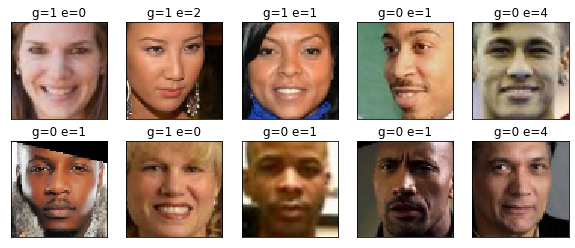

In [6]:
fig = plt.figure(figsize=(10, 4))
for i, (x, y1_true, y2_true) in enumerate(ds, start=1):
    ax = fig.add_subplot(2, 5, i)
    image = x[0]
    gender = y1_true[0][0].numpy()
    ethnicity = y2_true[0][0].numpy()
    ax.imshow(image)
    ax.set_title('g={} e={}'.format(gender, ethnicity))
    ax.set_xticks([])
    ax.set_yticks([])
    if i == 10:
        break

## 2 Implementación del modelo

In [7]:
class VanillaCNN(tf.keras.Model):

  def __init__(self):
    super(VanillaCNN, self).__init__()
    self.conv1 = Conv2D(8, 3, padding='same', name='conv1')
    self.pool1 = MaxPooling2D(pool_size=2, padding='same', name='pool1')
    self.conv2 = Conv2D(16, 3, padding='same', name='conv2')
    self.pool2 = MaxPooling2D(pool_size=2, padding='same', name='pool2')
    self.conv3 = Conv2D(32, 3, padding='same', name='conv3')
    self.pool3 = MaxPooling2D(pool_size=2, padding='same', name='pool3')
    self.conv4 = Conv2D(64, 3, padding='same', name='conv4')
    self.pool4 = MaxPooling2D(pool_size=2, padding='same', name='pool4')
    self.flat = Flatten(name='flatten')
    self.t1_fc1 = Dense(128, name='t1_fc1')
    self.t1_fc2 = Dense(1, name='t1_fc2')
    self.t2_fc1 = Dense(128, name='t2_fc1')
    self.t2_fc2 = Dense(5, name='t2_fc2')

  def call(self, x):
    #####################
    # (N, 64, 64, 3) =>
    # (N, 64, 64, 8)
    x = self.conv1(x)
    # (N, 64, 64, 8) =>
    # (N, 32, 32, 8)
    x = self.pool1(x)
    # (N, 32, 32, 8)
    x = tf.nn.relu(x)
    #####################
    # (N, 32, 32, 8) =>
    # (N, 32, 32, 16)
    x = self.conv2(x)
    # (N, 32, 32, 16) =>
    # (N, 16, 16, 16)
    x = self.pool2(x)
    # (N, 16, 16, 16)
    x = tf.nn.relu(x)
    #####################
    # (N, 16, 16, 16) =>
    # (N, 16, 16, 32)
    x = self.conv3(x)
    # (N, 16, 16, 32) =>
    # (N, 8, 8, 32)
    x = self.pool3(x)
    # (N, 8, 8, 32)
    x = tf.nn.relu(x)
    #####################
    # (N, 8, 8, 32) =>
    # (N, 8*8*32)
    x = self.flat(x)
    #####################
    # T1
    # (N, 8*8*32) =>
    # (N, 128)
    y1_pred = self.t1_fc1(x)
    # (N, 128) =>
    # (N, 1)
    y1_pred = self.t1_fc2(y1_pred)
    # (N, 1)
    y1_pred = tf.nn.sigmoid(y1_pred)
    #####################
    # T1
    # (N, 8*8*32) =>
    # (N, 128)
    y2_pred = self.t2_fc1(x)
    # (N, 128) =>
    # (N, 5)
    y2_pred = self.t2_fc2(y2_pred)
    # (N, 5)
    y2_pred = tf.nn.softmax(y2_pred)
    # final output
    return y1_pred, y2_pred

## 3 Entrenamiento

### 3.1 Función de pérdida y optimizador

In [8]:
# pérdidas
loss_fn1 = tf.keras.losses.BinaryCrossentropy()
loss_fn2 = tf.keras.losses.SparseCategoricalCrossentropy()

# gradiente descendente
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

### 3.2 Métricas: pérdida y exactitud

In [9]:
# historiales a nivel época
loss_epoch1 = tf.keras.metrics.Mean()
loss_epoch2 = tf.keras.metrics.Mean()
loss_epoch = tf.keras.metrics.Mean()

acc_epoch1 = tf.keras.metrics.BinaryAccuracy()
acc_epoch2 = tf.keras.metrics.SparseCategoricalAccuracy()

# historiales a nivel entrenamiento
loss_history1 = []
loss_history2 = []
loss_history = []

acc_history1 = []
acc_history2 = []

### 3.3 Ciclo de entrenamiento

In [10]:
model = VanillaCNN()

beta1, beta2 = 1.0, 1.0

# épocas de entrenamiento
for epoch in range(20):
    # pasos de entrenamiento
    for step, (x, y1_true, y2_true) in enumerate(ds):
    
        # registramos el flujo del cómputo en GradientTape
        with tf.GradientTape() as tape:
            
            # realizamos inferencia con el lote 
            y1_pred, y2_pred = model(x)
            
            # computamos las pérdias
            loss1 = loss_fn1(y1_true, y1_pred)
            loss2 = loss_fn2(y2_true, y2_pred)
            loss = loss1 * beta1 + loss2 * beta2
        
        # computamos los gradientes de los parámetros del modelo
        gradients = tape.gradient(loss, model.trainable_weights)
        # aplicamos los gradientes
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        
        # calculamos las métricas y agramos al historial de la época
        loss_epoch1(loss1 * beta1)
        loss_epoch2(loss2 * beta2)
        loss_epoch(loss)
        acc_epoch1(y1_true, y1_pred)
        acc_epoch2(y2_true, y2_pred)
    
    # guardamos las métricas de la época
    loss_epoch_res1 = loss_epoch1.result().numpy() * 100
    loss_epoch_res2 = loss_epoch2.result().numpy() * 100
    loss_epoch_res = loss_epoch.result().numpy() * 100
    acc_epoch_res1 = acc_epoch1.result().numpy() * 100
    acc_epoch_res2 = acc_epoch2.result().numpy() * 100
    
    # reiniciamos los historiales de las épocas
    loss_epoch1.reset_states()
    loss_epoch2.reset_states()
    loss_epoch.reset_states()
    acc_epoch1.reset_states()
    acc_epoch2.reset_states()
    
    # agreagmos a los historiales nivel entrenamiento
    loss_history1.append(loss_epoch_res1)
    loss_history2.append(loss_epoch_res2)
    loss_history.append(loss_epoch_res)
    acc_history1.append(acc_epoch_res1)
    acc_history2.append(acc_epoch_res2)
    
    # imprimimos métricas
    print('{:2d} loss={:6.2f}, loss1={:6.2f}, acc1={:6.2f}, loss2={:6.2f}, acc2={:6.2f}'.format(
        epoch, loss_epoch_res, loss_epoch_res1, acc_epoch_res1, loss_epoch_res2, acc_epoch_res2))

 0 loss=196.56, loss1= 58.07, acc1= 69.98, loss2=138.50, acc2= 44.68
 1 loss=160.51, loss1= 44.42, acc1= 80.70, loss2=116.09, acc2= 55.46
 2 loss=138.30, loss1= 35.46, acc1= 85.81, loss2=102.84, acc2= 62.18
 3 loss=126.15, loss1= 31.05, acc1= 88.05, loss2= 95.10, acc2= 65.94
 4 loss=118.74, loss1= 28.72, acc1= 89.04, loss2= 90.01, acc2= 68.24
 5 loss=113.44, loss1= 27.18, acc1= 89.64, loss2= 86.26, acc2= 69.91
 6 loss=109.28, loss1= 26.00, acc1= 90.21, loss2= 83.29, acc2= 71.12
 7 loss=105.83, loss1= 25.01, acc1= 90.62, loss2= 80.82, acc2= 72.13
 8 loss=102.86, loss1= 24.14, acc1= 90.97, loss2= 78.72, acc2= 72.78
 9 loss=100.27, loss1= 23.38, acc1= 91.30, loss2= 76.89, acc2= 73.52
10 loss= 97.96, loss1= 22.70, acc1= 91.60, loss2= 75.27, acc2= 74.07
11 loss= 95.88, loss1= 22.07, acc1= 91.90, loss2= 73.81, acc2= 74.51
12 loss= 93.98, loss1= 21.52, acc1= 92.18, loss2= 72.47, acc2= 75.02
13 loss= 92.25, loss1= 21.00, acc1= 92.44, loss2= 71.25, acc2= 75.51
14 loss= 90.67, loss1= 20.54, acc1

### 3.4 Gráfica de pérdidas

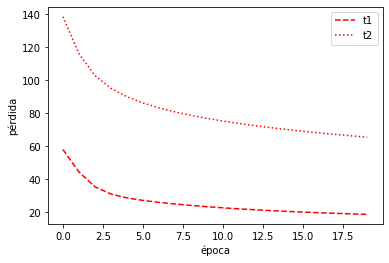

In [11]:
plt.plot(loss_history1, linestyle='--', color='red', label='t1')
plt.plot(loss_history2, linestyle=':', color='red', label='t2')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.legend(loc='upper right')
plt.show()

### 3.5 Gráfica de exactitudes

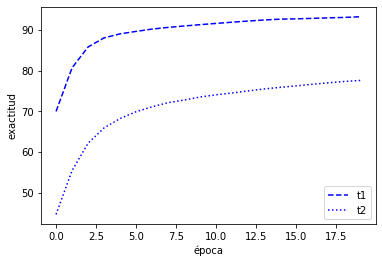

In [12]:
plt.plot(acc_history1, linestyle='--', color='blue', label='t1')
plt.plot(acc_history2, linestyle=':', color='blue', label='t2')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.legend(loc='lower right')
plt.show()